# Test API

To test the API submission process

In [2]:
import traceback
import numpy as np
import pandas as pd
#import datatable as dt
import gc
import time
import os
import xgboost as xgb
import talib as ta
from script.crypto_API import *

## Model Version

In [7]:
ASSET_DETAILS_CSV = './data/asset_details.csv'
df_asset_details = pd.read_csv(ASSET_DETAILS_CSV).sort_values("Asset_ID")

version = 40 #36
retrained = True
if retrained:
    MOD_FOLDER = "./trainedXGB/retrained" + f"/model_nof_{version}_sub_sub"
else:
    MOD_FOLDER = "./trainedXGB" + f"/model_nof_{version}"

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

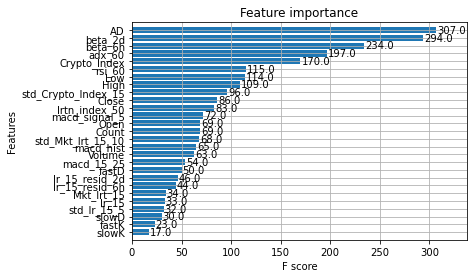

In [8]:
from os.path import exists
def model_reload_train():
    models = {}
    for asset_id, asset_name in zip(df_asset_details['Asset_ID'], df_asset_details['Asset_Name']):
        #model_file = f"./trainedXGB/model_nof_{param_version}/model_{asset_id}.json"
        model_file = MOD_FOLDER + f"/model_{asset_id}.json"
        if exists(model_file):
            model = xgb.Booster()
            model.load_model(model_file)
            models[asset_id] = model
    return models

models = model_reload_train()
xgb.plot_importance(models[1],height=0.8)

In [9]:
models[0].feature_names

['Count',
 'Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'lr_15',
 'Mkt_lrt_15',
 'Crypto_Index',
 'beta_6h',
 'lr_15_resid_6h',
 'beta_2d',
 'lr_15_resid_2d',
 'lrtn_index_50',
 'slowK',
 'slowD',
 'fastK',
 'fastD',
 'rsi_60',
 'macd_15_25',
 'macd_signal_5',
 'macd_hist',
 'adx_60',
 'AD',
 'std_lr_15_5',
 'std_Mkt_lrt_15_10',
 'std_Crypto_Index_15']

## get_features

In [10]:
# psets34 = dict(zip(['lrtn','fastk1','fastk2','adx','macd_s','macd_l','rsi','std_Crypto_Index','std_lr_15','std_Mkt_lrt_15'],
#                    [15, 15, 5, 30, 5, 25, 60, 5, 15, 30]))
      
import pickle
with open("./trainedXGB" + f"/model_nof_{version}" + f"/feature_best{version}", "rb") as f:
    psets=pickle.load(f)
    
psets

{'std_lr_15': 5,
 'std_Mkt_lrt_15': 10,
 'std_Crypto_Index': 15,
 'rsi': 60,
 'macd_sig': 5,
 'macd_s': 15,
 'macd_l': 25,
 'lrtn': 50,
 'fastk2': 15,
 'fastk1': 5,
 'beta_s': '6h',
 'beta_l': '2d',
 'adx': 60}

In [12]:
def log_return(series, periods=5):
    return np.log(series).diff(periods)


def lag_features(df, fastk1,fastk2,adx,macd_s,macd_l,macd_sig,rsi,std_Crypto_Index,std_lr_15,std_Mkt_lrt_15, **kwargs):    
    ####TECH indicators
    df['slowK'], df['slowD'] = ta.STOCH(df.High, df.Low, df.Close, 
                                        fastk_period=fastk1, slowk_period=int(3*fastk1/5), slowd_period=int(3*fastk1/5),
                                        slowk_matype=0, slowd_matype=0)
    df['fastK'], df['fastD'] = ta.STOCHF(df.High, df.Low, df.Close,
                                         fastk_period=fastk2, fastd_period=int(3*fastk2/5), 
                                         fastd_matype=0)
    df[f'rsi_{rsi}'] = ta.RSI(df['Close'], timeperiod=rsi)
    df[f'macd_{macd_s}_{macd_l}'],df[f'macd_signal_{macd_sig}'], df['macd_hist'] = \
                ta.MACD(df['Close'],fastperiod=macd_s, slowperiod=macd_l, signalperiod=macd_sig)
    df[f'adx_{adx}'] = ta.ADX(df['High'], df['Low'],df['Close'], timeperiod=adx)#Average Directional Movement Index
    df['AD'] = ta.AD(df['High'], df['Low'],df['Close'], df['Volume'])#Accumulation Distribution Line
    ####std volatility
    df[f'std_lr_15_{std_lr_15}'] = ta.STDDEV(df.lr_15,timeperiod=std_lr_15, nbdev=1)
    df[f'std_Mkt_lrt_15_{std_Mkt_lrt_15}'] = ta.STDDEV(df.Mkt_lrt_15,timeperiod=std_Mkt_lrt_15, nbdev=1)
    df[f'std_Crypto_Index_{std_Crypto_Index}'] = ta.STDDEV(df.Crypto_Index,timeperiod=std_Crypto_Index, nbdev=1)

# mod>=36
# def beta_resid(df, window): 
#     num, unit = int(window[:-1]),window[-1]
#     if unit == 'h':
#         width = 60*num
#     elif unit == 'd':
#         width = 60*24*num
#     b = ((ta.MULT(df.Mkt_lrt_15,df.lr_15).rolling(width).mean())/ \
#         (ta.MULT(df.Mkt_lrt_15,df.Mkt_lrt_15).rolling(width).mean()))#.rename(f"beta_{window}")
#     b = b.replace([np.nan,np.inf,-np.inf], 0)
    
#     #resids = ta.SUB(df.lr_15, ta.MULT(b, df.Mkt_lrt_15)).rename(f"lr_15_resid_{window}")
#     return b #pd.concat([b, resids],axis=1)
## mod>=40
def beta_resid(df, width): 
    b = ((ta.MULT(df.Mkt_lrt_15,df.lr_15).mean())/ \
        (ta.MULT(df.Mkt_lrt_15,df.Mkt_lrt_15).mean()))
    if b in [np.nan,np.inf,-np.inf]:
        b=0
    return b 


def get_features(df_feat, psets):
    pd.options.mode.chained_assignment = None  # default='warn'
    df_feat[f"lr_15_resid_{psets['beta_s']}"] = ta.SUB(df_feat.lr_15, ta.MULT(df_feat[f"beta_{psets['beta_s']}"], df_feat.Mkt_lrt_15)).rename(f"lr_15_resid_{psets['beta_s']}")
    df_feat[f"lr_15_resid_{psets['beta_l']}"] = ta.SUB(df_feat.lr_15, ta.MULT(df_feat[f"beta_{psets['beta_l']}"], df_feat.Mkt_lrt_15)).rename(f"lr_15_resid_{psets['beta_l']}")
    df_feat[f"lrtn_index_{psets['lrtn']}"] = log_return(df_feat.Crypto_Index, psets['lrtn'])
    lag_features(df_feat, **psets)
    return df_feat

## API submission

In [13]:
start = datestring_to_timestamp('2021-06-13T00:00:00')#2021-11-05T07:18:57
#end = datestring_to_timestamp('2021-09-21T00:00:00')
end = datestring_to_timestamp('2021-06-13T01:00:00')
train_df = read_csv_slice(file_path='./data/train.csv', 
                          use_window=[start, end])

In [18]:
def beta_window(beta):
    num, unit = int(beta[:-1]),beta[-1]
    if unit == 'h':
        width = 60*num
    elif unit == 'd':
        width = 60*24*num
    return width

beta_sw = beta_window(psets['beta_s'])
beta_lw = beta_window(psets['beta_l'])
#beta_lw = min(beta_lw,1000)

######################################################
pre_minute=65
if version < 35:
    pre_minute_beta = pre_minute
else:
    # num, unit = int(psets[version]['beta_l'][:-1]), psets[version]['beta_l'][-1]
    # if unit == 'h':
    #     width = 60*num
    # elif unit == 'd':
    #     width = 60*24*num
    # pre_minute_beta = width + 15
    pre_minute_beta =  beta_lw + 15

   
add_weight_map = dict(zip(df_asset_details.Asset_ID, 
                        df_asset_details.Weight/df_asset_details.Weight.sum()))

###load sup_train
sup_train = pd.read_csv('./data/supplemental_train.csv')
sup_train = sup_train.sort_values('timestamp').set_index("timestamp")
ind = sup_train.index.unique()
###consistent timestamp for all 14 assets
def reindex(df):
    df = df.reindex(range(ind[0],ind[-1]+60,60),method='nearest')
    df = df.fillna(method="ffill").fillna(method="bfill")
    return df
sup_train = sup_train.groupby('Asset_ID').apply(reindex).reset_index(0, drop=True).sort_index()
sup_train = sup_train.iloc[(-14*pre_minute_beta):,:]
#clean VWAP
sup_train.replace(to_replace=[np.inf, -np.inf],value= np.nan, inplace=True)
sup_train['VWAP']=sup_train['VWAP'].fillna((sup_train['High']+sup_train['Low'])/2)
#add weight
sup_train['Weight'] = sup_train['Asset_ID'].map(add_weight_map)
sup_train.drop('Target',axis=1, inplace=True)
sup_train.set_index('Asset_ID',append=True, inplace=True)
#######################################add lr_15,mkt_lr_15,crypto_index, beta,lr_mkt_resid
lr_15 = sup_train.groupby('Asset_ID').apply( 
        lambda x: log_return(x[['Close']],15)
        )
sup_train['lr_15'] = lr_15['Close']

mkt_lr_15 = sup_train.groupby('timestamp').apply( 
    lambda x: x[["lr_15", "Close"]].multiply(x["Weight"], axis="index").sum()
    )
mkt_lr_15.columns = ['Mkt_lrt_15','Crypto_Index']
firsts = sup_train.index.get_level_values('timestamp')
sup_train[['Mkt_lrt_15','Crypto_Index']] = mkt_lr_15.loc[firsts].values
####make beta,lr_mkt_resid, placeholder
sup_train[f"beta_{psets['beta_s']}"] = 0
sup_train[f"beta_{psets['beta_l']}"] = 0
sup_train.iloc[-14:,]

Count          Open          High           Low  \
timestamp  Asset_ID                                                     
1641772800 6         2059.0   3151.504286   3152.150000   3143.790000   
           11          52.0    190.732000    191.160000    189.800000   
           10          20.0   2122.416667   2124.010000   2116.950000   
           9          218.0    130.842571    130.940000    130.478000   
           8           29.0      1.034633      1.075000      0.957800   
           7           75.0     29.731780     29.751000     29.698200   
           5           88.0      2.794480      2.800000      2.788562   
           4          197.0      0.150498      0.150600      0.150200   
           3          351.0      1.170103      1.170729      1.167000   
           2          106.0    376.696667    376.950000    376.000000   
           1         2111.0  41860.168571  41877.700000  41766.700000   
           0          288.0    438.722333    438.800000    437.700000   
           12         112.0      0.261055      0.261185      0.260474   
           13         118.0      0.066109      0.066130      0.066058   

                            Close        Volume          VWAP    Weight  \
timestamp  Asset_ID                                                       
1641772800 6          3147.158571  5.786272e+02   3148.128143  0.144188   
           11          190.506000  1.355932e+02    190.622811  0.039370   
           10         2119.743333  2.084755e+00   2120.570582  0.026874   
           9           130.707429  1.011042e+03    130.734076  0.058657   
           8             1.034400  8.585877e+03      1.034341  0.026874   
           7            29.715100  1.063943e+03     29.721728  0.050867   
           5             2.789640  2.411353e+04      2.792239  0.033911   
           4             0.150307  1.145598e+06      0.150394  0.086971   
           3             1.167863  1.692235e+05      1.168722  0.107797   
           2           376.480000  1.443180e+02    376.560393  0.058657   
           1         41823.085714  8.982209e+01  41830.240059  0.165850   
           0           437.990333  4.016819e+02    438.278705  0.105286   
           12            0.260682  1.187581e+05      0.260913  0.050867   
           13            0.066082  1.265238e+06      0.066086  0.043830   

                        lr_15  Mkt_lrt_15  Crypto_Index  beta_6h  beta_2d  
timestamp  Asset_ID                                                        
1641772800 6        -0.003110   -0.003263   7532.261935        0        0  
           11       -0.000454   -0.003263   7532.261935        0        0  
           10       -0.003462   -0.003263   7532.261935        0        0  
           9        -0.004696   -0.003263   7532.261935        0        0  
           8        -0.001899   -0.003263   7532.261935        0        0  
           7        -0.003969   -0.003263   7532.261935        0        0  
           5        -0.005577   -0.003263   7532.261935        0        0  
           4        -0.003500   -0.003263   7532.261935        0        0  
           3        -0.005190   -0.003263   7532.261935        0        0  
           2        -0.002764   -0.003263   7532.261935        0        0  
           1        -0.002324   -0.003263   7532.261935        0        0  
           0        -0.002281   -0.003263   7532.261935        0        0  
           12       -0.003568   -0.003263   7532.261935        0        0  
           13       -0.003493   -0.003263   7532.261935        0        0

In [20]:
myapi = API(train_df)
from datetime import datetime 
start_time = datetime.now()

for df_test, df_pred in myapi:
    num_asset_test = df_test.shape[0]
    row_asset_id_map = dict(zip(df_test.row_id, df_test.Asset_ID))
    test_timestamp = df_test.timestamp.values[0]
    
    timestamp_list = sup_train.index.get_level_values('timestamp').unique().values
    timestamp_list = np.append(timestamp_list,test_timestamp)
    #######################################format df_test
    ###add weight and index
    df_test['Weight'] = df_test['Asset_ID'].map(add_weight_map)
    ###fillin missing assets as nan
    df_test.set_index(['timestamp','Asset_ID'],inplace=True)
    df_test = df_test.reindex(list(zip([test_timestamp]*14,range(14))))
    ########################################concat to sup_train, add lr_15,mkt_lr_15,crypto_index
    sup_train = pd.concat([sup_train,df_test.drop('row_id',axis=1)],join='outer')
    test_lr_15 = sup_train.loc[timestamp_list[[-16,-1]]].groupby('Asset_ID').apply(
        lambda x: np.log(x[['Close']]).diff()
    )
    sup_train.loc[test_timestamp, 'lr_15'] = test_lr_15.loc[test_timestamp,'Close'].values
    sup_train.loc[test_timestamp, ['Mkt_lrt_15','Crypto_Index']] = sup_train.loc[test_timestamp, ["lr_15", "Close"]].multiply(sup_train.loc[test_timestamp,"Weight"], axis="index").sum().values
    ########################################beta_sl
    beta_s = sup_train[['lr_15','Mkt_lrt_15']].iloc[-14*(beta_sw):,:].groupby('Asset_ID').apply(
        lambda x: beta_resid(x,beta_sw)
    ).rename(f"beta_{psets['beta_s']}")
    beta_l = sup_train[['lr_15','Mkt_lrt_15']].iloc[-14*(beta_lw):,:].groupby('Asset_ID').apply(
        lambda x: beta_resid(x,beta_lw)
    ).rename(f"beta_{psets['beta_l']}")
    sup_train.loc[test_timestamp, [f"beta_{psets['beta_s']}",f"beta_{psets['beta_l']}"]] = \
        pd.concat([beta_s, beta_l],axis=1).values
    #########################################fill in missing assets as forward
    if num_asset_test <14:
        #ffill in missing
        sup_train = sup_train.groupby('Asset_ID').apply(lambda x: x.fillna(method="ffill")).iloc[14:,:]
    else:
        sup_train = sup_train.iloc[14:,:]
    #######################################add features to test timestamp
    sup_train2 = sup_train.iloc[(-14*pre_minute):,:].copy()
    xx_test=sup_train2.groupby('Asset_ID').apply(
        lambda x: get_features(x,psets)
    ).loc[test_timestamp]
    
    #rdy for prediction
    y_pred=df_test.apply(lambda row: models[row.name[1]].predict(
                            xgb.DMatrix(pd.DataFrame([xx_test.loc[row.name[1],models[row.name[1]].feature_names]]))
                                                                )[-1]
                         ,axis =1)
    #match with row_id
    y_pred.reset_index('timestamp',drop=True,inplace=True)
    df_pred['Target']= y_pred.loc[df_pred['row_id'].map(row_asset_id_map)].values
    myapi.predict(df_pred)

time_elapsed = datetime.now() - start_time
print('Time elapsed total (hh:mm:ss.ms) {}'.format(time_elapsed))
print(f'time elapsed per iteration {time_elapsed/myapi.init_num_times}')
print(f'Submission time estimate {129600*time_elapsed/myapi.init_num_times}')


This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set. ;)
Time elapsed total (hh:mm:ss.ms) 0:00:04.658733
time elapsed per iteration 0:00:00.077646
Submission time estimate 2:47:42.863280


In [21]:
##scoring
id_2_weight = dict(zip(df_asset_details.Asset_ID, df_asset_details.Weight))
df, score = myapi.score(id_2_weight)
print(f"Your LB score is {round(score, 4)}")

Your LB score is -0.0567


In [22]:
myapi.predictions

[            row_id    Target
 22221694  22221694 -0.006414
 22221695  22221695 -0.006368
 22221696  22221696  0.000739
 22221697  22221697 -0.001253
 22221698  22221698 -0.044931
 22221699  22221699 -0.002019
 22221700  22221700 -0.045850
 22221701  22221701  0.001307
 22221702  22221702  0.001336
 22221703  22221703 -0.002694
 22221704  22221704  0.011212
 22221705  22221705 -0.533567
 22221706  22221706  0.917616
 22221707  22221707 -0.011080,
             row_id    Target
 22221708  22221708 -0.007843
 22221709  22221709 -0.006058
 22221710  22221710  0.000884
 22221711  22221711 -0.001199
 22221712  22221712 -0.061188
 22221713  22221713 -0.004939
 22221714  22221714 -0.050165
 22221715  22221715  0.000806
 22221716  22221716  0.000659
 22221717  22221717 -0.001795
 22221718  22221718  0.010084
 22221719  22221719  0.275237
 22221720  22221720  0.718352
 22221721  22221721 -0.010376,
             row_id    Target
 22221722  22221722 -0.007949
 22221723  22221723 -0.005459
 2222172